# Virtual Neuron example

In this example we set up a larger network of neurons, then the network is modified so that only a few core neurons remain normal, while the rest of the population is changed to be virtual neurons. Virtual neurons are not simulated, instead their activity is represented by data read from file. All the synapses in the network remain though. This allows the user to simulate a subset of the network, but retaining the full input those neurons should have received if all the neurons had been simulated normally.

In [1]:
import os
import numpy as np

number_of_neurons = 100
num_sim_neurons = 20
network_path = os.path.join("networks","virtual_network_example")
modified_network_file = os.path.join(network_path, "modified-network.hdf5")

%matplotlib inline


## Start ipcluster and set ```SNUDDA_DATA```

In [2]:
os.environ["IPYTHONDIR"] = os.path.join(os.path.abspath(os.getcwd()), ".ipython")
os.environ["IPYTHON_PROFILE"] = "default"
os.system("ipcluster start -n 4 --profile=$IPYTHON_PROFILE --ip=127.0.0.1 --log-level ERROR 2> parallel-log.txt &")

import time
time.sleep(10) # Wait for ipcluster to start

In [3]:
import snudda
# Check if the user has the updated BasalGangliaData installed, if not use the old data provided
bg_path = "../../../../BasalGangliaData/data/"
if os.path.isdir(bg_path) and False:
    snudda_data = bg_path
else:
    snudda_data = os.path.join(os.path.dirname(snudda.__file__), "data")

In [4]:
snudda_data

'/home/hjorth/HBP/Snudda/snudda/data'

In [5]:
import os
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, random_seed=12345, snudda_data=snudda_data)
si.define_striatum(num_dSPN=np.ceil(number_of_neurons/2), num_iSPN=np.ceil(number_of_neurons/2), num_FS=0, num_LTS=0, num_ChIN=0,
                    volume_type="cube", neurons_dir="$DATA/neurons")
si.write_json()

Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum
FS: Skipping neuron because, num_neurons =0
Adding neurons: dSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn
ChIN: Skipping neuron because, num_neurons =0
LTS: Skipping neuron because, num_neurons =0
No directory $DATA/neurons/striatum/ngf, skipping NGF cells.
Writing networks/virtual_network_example/network-config.json


In [6]:
from snudda import Snudda
snd = Snudda(network_path=network_path, parallel=True, ipython_profile="default")
snd.create_network()

Placing neurons
Network path: networks/virtual_network_example
Reading IPYPARALLEL connection info from /home/hjorth/HBP/Snudda/examples/notebooks/VirtualNeurons/.ipython/profile_default/security/ipcontroller-client.json

Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/data from networks/virtual_network_example/network-config.json
Generating 771 points for networks/virtual_network_example/mesh/Striatum-cube-mesh-0.00010749824478388102.obj
n_points = 734, previous close_pairs = 1365
n_points = 699, previous close_pairs = 1122
n_points = 665, previous close_pairs = 923
n_points = 633, previous close_pairs = 772
n_points = 603, previous close_pairs = 645
n_points = 575, previous close_pairs = 534
n_points = 549, previous close_pairs = 449
n_points = 525, previous close_pairs = 372
n_points = 503, previous close_pairs = 305
n_points = 484, previous close_pairs = 250
n_points = 466, previous close_pairs = 212
n_points = 450, previous close_pairs = 178
n_points = 436, previous close_pairs

In [7]:
if number_of_neurons <= 50:
    # Do not plot too large networks, as that will take a really long time
    from snudda.plotting import PlotNetwork
    pn = PlotNetwork(network_path)
    pn.plot()
    pn.close()

# Converting neurons to virtual neurons

We want to simulate the centre neurons, all other neurons are changed into virtual neurons.

In [8]:
from snudda.utils.ablate_network import SnuddaAblateNetwork
from snudda.utils import SnuddaLoad

sa = SnuddaAblateNetwork(network_file=network_path)
sl = sa.snudda_load
virtual_idx = sorted(list(set(sl.iter_neuron_id()) - set([x for x,_ in sl.get_centre_neurons_iterator(n_neurons=num_sim_neurons)])))

sa.make_virtual(virtual_idx)
sa.write_network(modified_network_file)

Writing to networks/virtual_network_example/modified-network.hdf5
Keeping 100 neurons.
Making neuron id 0 (iSPN_3) virtual (old ID 0)
Making neuron id 1 (iSPN_1) virtual (old ID 1)
Making neuron id 2 (dSPN_2) virtual (old ID 2)
Making neuron id 3 (dSPN_1) virtual (old ID 3)
Making neuron id 4 (dSPN_2) virtual (old ID 4)
Making neuron id 5 (dSPN_3) virtual (old ID 5)
Making neuron id 6 (iSPN_0) virtual (old ID 6)
Making neuron id 7 (dSPN_2) virtual (old ID 7)
Making neuron id 8 (iSPN_0) virtual (old ID 8)
Making neuron id 9 (dSPN_0) virtual (old ID 9)
Making neuron id 10 (dSPN_2) virtual (old ID 10)
Making neuron id 12 (dSPN_1) virtual (old ID 12)
Making neuron id 13 (iSPN_2) virtual (old ID 13)
Making neuron id 14 (iSPN_1) virtual (old ID 14)
Making neuron id 15 (dSPN_3) virtual (old ID 15)
Making neuron id 17 (iSPN_2) virtual (old ID 17)
Making neuron id 19 (iSPN_1) virtual (old ID 19)
Making neuron id 20 (dSPN_1) virtual (old ID 20)
Making neuron id 25 (dSPN_3) virtual (old ID 25)
Ma

# Generate the input for the neurons, and the activity of the virtual neurons

In the ```"dSPN"``` and ```"iSPN"``` blocks we have added an ```"activity"``` field, which is used for the neurons that are turned into virtual neurons of that type.

```
	"virtual_neuron" : {
	    "spike_file": "virtual_input_spikes.txt",
	    "row_mapping_file": "virtual_input__mapping.txt"
	}	
```

In [9]:
from snudda.input.virtual_input import VirtualInput
vi = VirtualInput(spike_file="virtual_input_spikes.txt", mapping_file="virtual_input_mapping.txt")

for vidx in virtual_idx:
    vi.add_input(neuron_id=vidx, spike_times = vi.poisson_spikes(frequency=5, max_time=5))
    
vi.write_data()

In [10]:
snd.setup_input(network_file=modified_network_file, input_config="virtual-input.json")

Setting up inputs, assuming input.json exists
Reading IPYPARALLEL connection info from /home/hjorth/HBP/Snudda/examples/notebooks/VirtualNeurons/.ipython/profile_default/security/ipcontroller-client.json

Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/data from networks/virtual_network_example/network-config.json
Writing input spikes to networks/virtual_network_example/input-spikes.hdf5
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/data from networks/virtual_network_example/network-config.json
importing SnuddaInput from snudda.input.input on engine(s)
Writing spikes to networks/virtual_network_example/input-spikes.hdf5
stop_parallel disabled, to keep pool running.

Execution time: 7.8s


In [11]:
!ipcluster stop

2024-02-23 17:18:00.658 [IPClusterStop] Stopping cluster 
2024-02-23 17:18:00.658 [IPClusterStop] Stopping controller
2024-02-23 17:18:00.815 [IPClusterStop] Stopping engine(s): 1708705062


Important that we remember to use the modified network file for the input generation.

from snudda.input import SnuddaInput
sin = SnuddaInput(network_path=network_path, hdf5_network_file=modified_network_file, rc=rc, input_config_file="virtual-input.json")
sin.generate()

In [12]:
cmd_str = f"nrnivmodl {snudda_data}/neurons/mechanisms"
print(cmd_str)
os.system(cmd_str)

nrnivmodl /home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms
/home/hjorth/HBP/Snudda/examples/notebooks/VirtualNeurons
Mod files: "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/bk_ch.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/bk_fs.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/bk_ms.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/ca_ch.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/cadyn_fs.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/cadyn_ms.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/cal12_ms.mod" "/h

0

In [13]:
from snudda.simulate import SnuddaSimulate
sim = SnuddaSimulate(network_file=modified_network_file, network_path=network_path)
sim.setup()
sim.add_external_input()
sim.add_volt_recording_soma()
sim.run(500)  # 100 ms
sim.write_output()

Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/data from networks/virtual_network_example/network-config.json
0 : Memory status: 69% free
Empty mod_file field for ChIN -> dSPN synapses. This channel is IGNORED.
Empty mod_file field for ChIN -> iSPN synapses. This channel is IGNORED.
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e160118_c10_D2-m46-3-DE-v20190529/modulation.json
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c6_D1-m21-6-DE-v20190503/modulation.json
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150602_c1_D1-mWT-0728MSN01-v20190508/modulation.json
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c10_D1-mWT-P270-20-v20190521/modulation.json
Warning! No modulation key specified, ignoring /ho

In [14]:
from snudda.utils import SnuddaLoad
from snudda.utils import SnuddaLoadNetworkSimulation

sl = SnuddaLoad(modified_network_file)

sim_file = os.path.join(network_path, "simulation", "output.hdf5")

sls = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file)

Loading networks/virtual_network_example/simulation/output.hdf5
Failed sanity check on neuron ID, not all neurons simulated? [11 16 18 21 22 23 24 38 47 49 55 57 58 59 67 68 70 73 85 91]


Loading network info from networks/virtual_network_example/modified-network.hdf5
Loading input info from networks/virtual_network_example/input-spikes.hdf5
Loading networks/virtual_network_example/simulation/output.hdf5
Failed sanity check on neuron ID, not all neurons simulated? [11 16 18 21 22 23 24 38 47 49 55 57 58 59 67 68 70 73 85 91]
Plotting traces: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Plotted 100 traces (total 20)
Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/VirtualNeurons/networks/virtual_network_example/figures/Network-voltage-trace--dSPN-iSPN.pdf


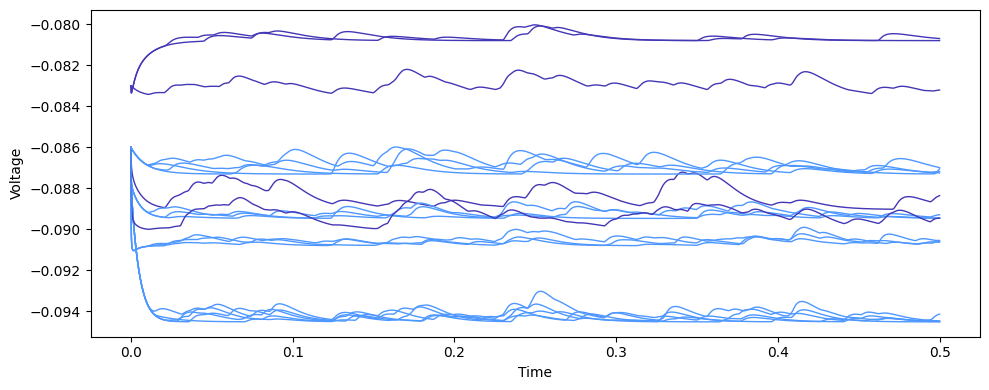

In [15]:
%matplotlib inline

from snudda.plotting.plot_traces import PlotTraces
pt = PlotTraces(output_file=sim_file, network_file=modified_network_file)
# Use trace_id to specify which traces
ax = pt.plot_traces(offset=0, time_range=(0,1.0),fig_size=(10,4))